# Practical Lab 3: Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

**Author**

Zhimin Xiong 9067935

**Introduction**

This practical lab is to work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand.

**Imports**

* note: all the libraries required to run the code cells in this notebook are listed in the requirements.txt. To test on a different machine, run ```pip install -r requirements.txt```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras import Sequential, Input, layers, models
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, average_precision_score, confusion_matrix

## Get Data

In [2]:
# define base directory
data_dir = "data/dogs_vs_cats_small"
data_dir_train = data_dir + "/train"

## EDA

In [3]:
# List of filenames
cat_files = os.listdir(data_dir_train + "/cat")
dog_files = os.listdir(data_dir_train + "/dog")

print(f"Number of dog images: {len(dog_files)}")
print(f"Number of cat images: {len(cat_files)}")

Number of dog images: 2500
Number of cat images: 2500


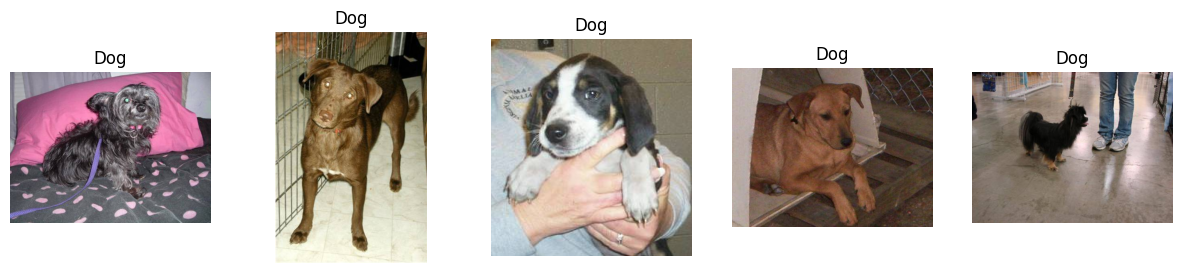

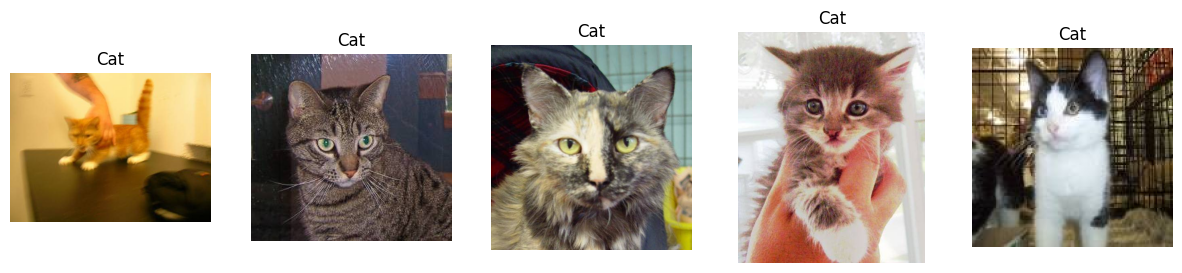

In [4]:
# Display 5 images for dog and cat
from PIL import Image

def show_images(image_list, folder, label, n=5):
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = data_dir_train +"/" + folder + "/" + image_list[i]
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.show()

# Show some dog and cat images
show_images(dog_files, "dog", "Dog")
show_images(cat_files, "cat", "Cat")


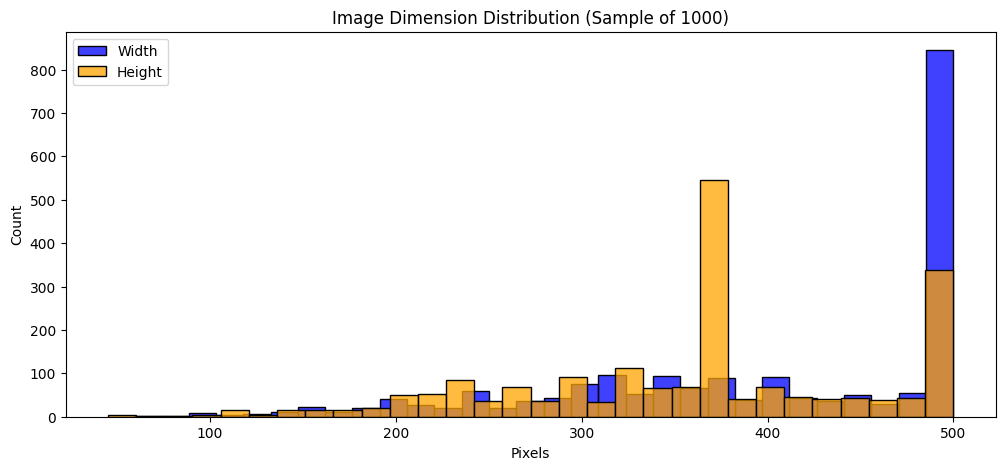

In [5]:
# Check image shapes
image_shapes = []

for img_file in cat_files[:1000]:  # sample 1000 for speed
    img_path = os.path.join(data_dir_train, "cat", img_file)
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

for img_file in dog_files[:1000]:  # sample 1000 for speed
    img_path = os.path.join(data_dir_train, "dog", img_file)
    with Image.open(img_path) as img:
        image_shapes.append(img.size)  # (width, height)

widths, heights = zip(*image_shapes)

# Plot size distribution
plt.figure(figsize=(12, 5))
sns.histplot(widths, bins=30, color='blue', label='Width')
sns.histplot(heights, bins=30, color='orange', label='Height')
plt.title("Image Dimension Distribution (Sample of 1000)")
plt.legend()
plt.xlabel("Pixels")
plt.show()

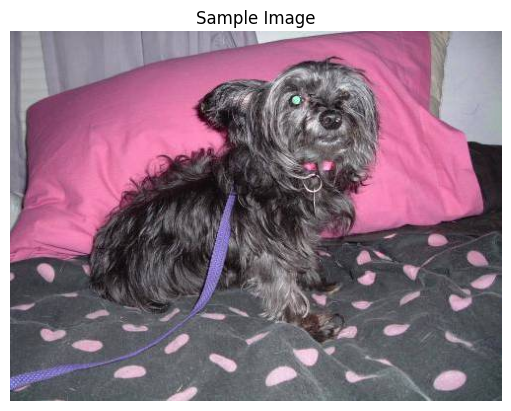

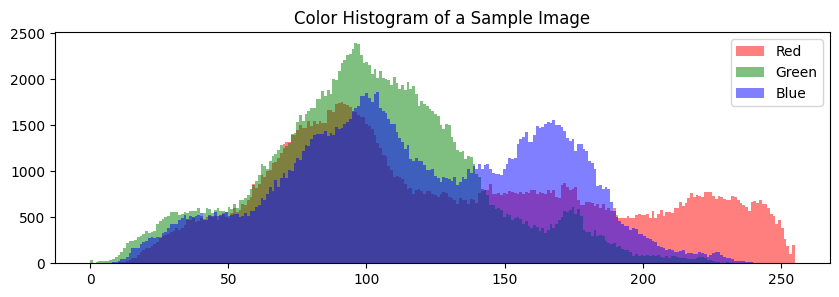

In [6]:
# Check color histogram of a sample image
sample_img = Image.open(os.path.join(data_dir_train, "dog", dog_files[0]))
plt.imshow(sample_img)
plt.axis('off')
plt.title("Sample Image")
plt.show()

# RGB histograms
r, g, b = sample_img.split()
plt.figure(figsize=(10, 3))
plt.hist(np.array(r).flatten(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(np.array(g).flatten(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(np.array(b).flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.title("Color Histogram of a Sample Image")
plt.legend()
plt.show()

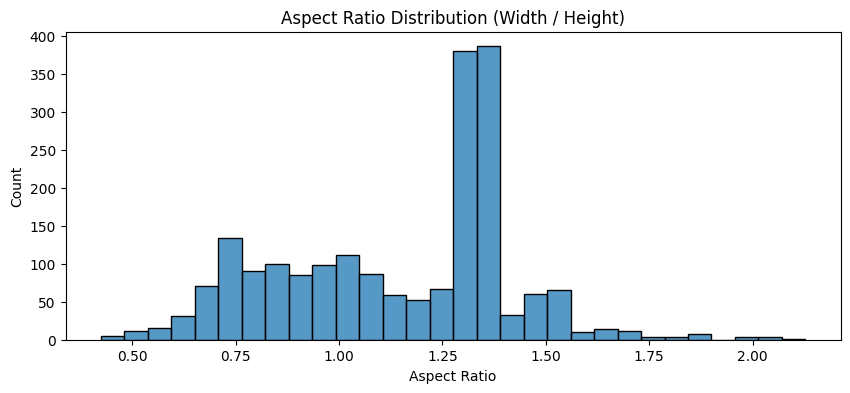

In [7]:
# Check image aspect ratios
aspect_ratios = [w/h for w, h in image_shapes]

plt.figure(figsize=(10, 4))
sns.histplot(aspect_ratios, bins=30)
plt.title("Aspect Ratio Distribution (Width / Height)")
plt.xlabel("Aspect Ratio")
plt.show()


**Insight**
* Images have different sizes 
* Images are colorful instead of grayscale

## Train Two Networks

### Generate the train / Validation / Test dataset

In [5]:
# Parameters
image_size = (150, 150)
batch_size = 32

# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=["train"],
    class_mode=None,  # we use filenames for labels
    shuffle=False
)

# Use tf.keras.utils.image_dataset_from_directory for better performance
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/train",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/validation",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

Found 5000 images belonging to 1 classes.
Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "/test",
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

Found 1000 files belonging to 2 classes.


### Common Functions

In [7]:
def model_checkpoint_callback(filepath):
    return ModelCheckpoint(
        filepath=filepath,         # Filepath to save
        monitor='val_accuracy',           # Metric to monitor
        save_best_only=True,              # Only save when it's the best so far
        save_weights_only=False,          # Save full model (change to True if you want weights only)
        mode='max',                       # 'max' for accuracy, 'min' for loss
        verbose=1                         # Show logs
    )

In [8]:
# function to get true labels and predicted probabilities
def validate(model, ds):
    y_true = []
    y_pred_prob = []

    for images, labels in ds: 
        preds = model.predict(images, verbose=0).flatten()
        y_true.extend(labels.numpy().tolist())
        y_pred_prob.extend(preds.tolist())

    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)

    # Convert probabilities to class predictions (0 or 1)
    y_pred = (y_pred_prob > 0.5).astype(int)

    return (y_true, y_pred, y_pred_prob)

In [9]:
# Function to calculate and display Accuracy, Confusion Matrix, Precision, Recall, F1
def display_performance(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("✅ Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    print("\n📊 Confusion Matrix:")
    print(cm)

In [10]:
# Plot the Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

### 1. Simple Feedforward Neural Network

In [11]:
# Define Feedforward Neural Network Model
input_shape = (150, 150, 3)

model_feedforward = Sequential([
    Input(shape=(150, 150, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')       # Binary classification
])

model_feedforward.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_feedforward.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648,449 (32.99 MB)

 Trainable params: 8,648,449 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the Model
checkpoint_cb__feedforward = model_checkpoint_callback("models/best_model_feedforward.keras")

history_feedforward = model_feedforward.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb__feedforward]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5077 - loss: 789.5159
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5077 - loss: 787.2758 - val_accuracy: 0.5000 - val_loss: 251.5591
Epoch 2/10
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5114 - loss: 209.7600
Epoch 2: val_accuracy did not improve from 0.50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5117 - loss: 208.6796 - val_accuracy: 0.5000 - val_loss: 154.6300
Epoch 3/10
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5168 - loss: 100.8410
Epoch 3: val_accuracy improved from 0.50000 to 0.54400, saving model to models/best_model_feedforward.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5169 - loss: 100.5245 - val_accuracy: 0.5440 - val_loss: 25.3829
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5446 - loss: 40.0604
Epoch 4: val_a

In [13]:
# Load best model
best_model_feedforward = load_model('models/best_model_feedforward.keras')
# Get true labels and predicted probabilities
y_true, y_pred, y_pred_prob = validate(best_model_feedforward, test_ds)

In [14]:
# Performance metrics
display_performance(y_true, y_pred)

✅ Evaluation Metrics:
Accuracy:  0.5770
Precision: 0.5469
Recall:    0.8980
F1 Score:  0.6798

📊 Confusion Matrix:
[[128 372]
 [ 51 449]]


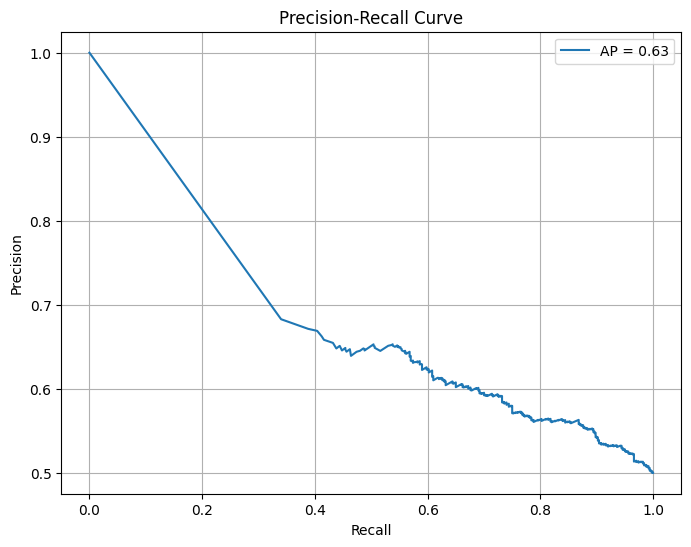

In [15]:
# Precision recall curve
plot_precision_recall_curve(y_true, y_pred_prob)

###  2. Convolutional Neural Network (CNN)

In [16]:
# Build the CNN Model
model_cnn = Sequential([
    Input(shape=(150, 150, 3)),  
    layers.Rescaling(1./255), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')           # Binary classification
])

model_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the Model
checkpoint_cb_cnn = model_checkpoint_callback("models/best_model_cnn.keras")

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb_cnn]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5318 - loss: 0.8648
Epoch 1: val_accuracy improved from -inf to 0.58400, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 288ms/step - accuracy: 0.5320 - loss: 0.8639 - val_accuracy: 0.5840 - val_loss: 0.6665
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6376 - loss: 0.6450
Epoch 2: val_accuracy improved from 0.58400 to 0.64800, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 289ms/step - accuracy: 0.6377 - loss: 0.6449 - val_accuracy: 0.6480 - val_loss: 0.6345
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6881 - loss: 0.5886
Epoch 3: val_accuracy improved from 0.64800 to 0.66000, saving model to models/best_model_cnn.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 288ms/step - accuracy: 0.6882 - loss: 0.5884 - val_accuracy: 0.6600 - val_loss: 0.6610
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7482 - loss

In [18]:
# Load best model
best_model_cnn = load_model('models/best_model_cnn.keras')
# Get true labels and predicted probabilities
y_true_cnn, y_pred_cnn, y_pred_prob_cnn = validate(model_cnn, test_ds)

In [19]:
display_performance(y_true_cnn, y_pred_cnn)

✅ Evaluation Metrics:
Accuracy:  0.7440
Precision: 0.7500
Recall:    0.7320
F1 Score:  0.7409

📊 Confusion Matrix:
[[378 122]
 [134 366]]


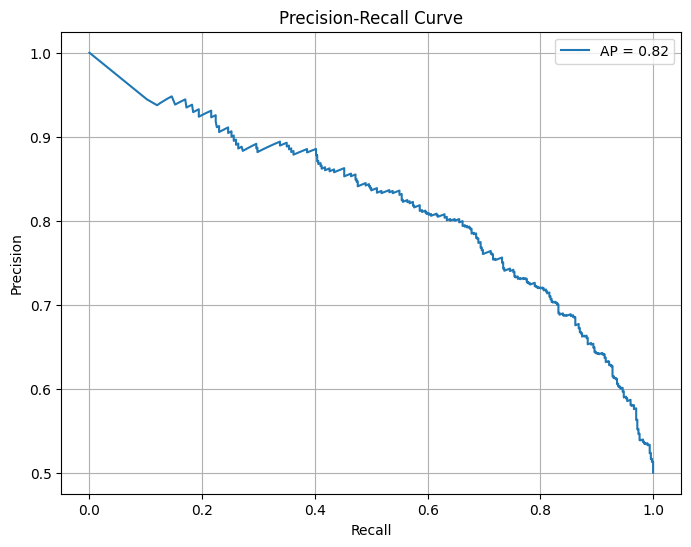

In [20]:
# Precision recall curve
plot_precision_recall_curve(y_true_cnn, y_pred_prob_cnn)